# Intro 

This notebook was used for the final sections of the capstone project including portions of the Result and Conclusion

# Robustness analysis

The first thing to identify is how robust my model is to small pertubations in the input data. To do this, I decided to make small tweaks to the final input test data and see how this influenced the final test predictions.

## Model setup

Before we can do any analysis, the first thing we need is set up the model from before. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor

%matplotlib inline

In [2]:
# Helper function to make splitting features and target easy!
def split_features_target(data): 
    return data.drop('SalePrice', axis=1), data['SalePrice']

def log_transform_features(data, columns, add_value=False): 
    value = 1 if add_value else 0
    
    for c in columns: 
        data['Log'+c] = data[c].apply(lambda x: np.log(x + value))
        data = data.drop(c, axis=1)
        
    return data

In [3]:
train_data = pd.read_csv('./data/train.csv')
test_data = pd.read_csv('./data/test.csv')

In [4]:
final_model_data = train_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                               'OverallQual', 'GrLivArea', 'Neighborhood', 
                               'TotalBsmtSF', 'GarageCars', 'ExterQual', 
                               'BsmtQual', 'KitchenQual', 'SalePrice']]
final_model_features, final_model_target = split_features_target(final_model_data)

In [5]:
final_model_processed_continuous_features = log_transform_features(final_model_features, 
                                                                   ['LotArea', 'GrLivArea', 'TotalBsmtSF'], add_value=True)
final_model_processed_features = pd.get_dummies(final_model_processed_continuous_features)
final_model_processed_features.head()

,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,3,2,2008,7,2,9.042040,7.444833,6.753438,0,0,...,1,0,0,0,1,0,0,0,1,0
1,3,5,2007,6,2,9.169623,7.141245,7.141245,0,0,...,0,1,0,0,1,0,0,0,0,1
2,3,9,2008,7,2,9.328212,7.488294,6.825460,0,0,...,1,0,0,0,1,0,0,0,1,0
3,3,2,2006,7,3,9.164401,7.448916,6.629363,0,0,...,0,1,0,0,0,1,0,0,1,0
4,4,12,2008,8,3,9.565284,7.695758,7.044033,0,0,...,1,0,0,0,1,0,0,0,1,0


In [6]:
final_model_processed_target = np.log(final_model_target)
final_model_processed_target.head()

0    12.247694
1    12.109011
2    12.317167
3    11.849398
4    12.429216
Name: SalePrice, dtype: float64

In [7]:
final_gb_model = GradientBoostingRegressor(loss='lad', max_depth=3, min_samples_leaf=1, 
                                     learning_rate=0.1, random_state=39, n_estimators=700)
final_gb_model.fit(final_model_processed_features, final_model_processed_target)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='lad', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=700, presort='auto', random_state=39,
             subsample=1.0, verbose=0, warm_start=False)

Now we can begin to measure robustness. As it turns out, there are two we can do that. One way to do that is by seeing how different methods of imputations can influence final outcomes. If you remember from before, the test set had three different features that had one missing value each. They were:  `GarageCars`, `TotalBsmtSF`, and `KitchenQual`. The first two were continuous while the last one was categorical. In the previous notebook, I used the mean of the column to fill in the missing data. But what happens if we used a different value (such as the median or the min value of the feature). By using a different value we can get a sense of the robustness of the model. 

To make things easier to understand, I am going to focus solely on the continuous features as those are easier to measure percent difference. 

## Null Fill test

The first thing I had to do was identify the null rows. One caveat to this process is that I had to run one-hot encoding first; if we ran one-hot encoding afterward, we wouldn't get all of the necessary columns for the categorical variable.  

In [8]:
final_model_test_features = test_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                                       'OverallQual', 'GrLivArea', 'Neighborhood', 
                                       'TotalBsmtSF', 'GarageCars', 'ExterQual', 
                                       'BsmtQual', 'KitchenQual']]

final_model_test_ohe_features = pd.get_dummies(final_model_test_features)

In [9]:
null_garage_row = final_model_test_ohe_features[final_model_test_ohe_features['GarageCars'].isnull()]
null_bsmtsf_row = final_model_test_ohe_features[final_model_test_ohe_features['TotalBsmtSF'].isnull()]

From there I created a helper function that took that null row and applied different imputation calculation (i.e. min, max, median, mean) to fill that na. Those modified rows were all returned as one giant dataframe. 

In [10]:
def create_different_fill_cases_df(row, df):
    min_fix = row.fillna(df.min())
    mean_fix = row.fillna(df.mean())
    median_fix = row.fillna(df.median())
    max_fix = row.fillna(df.max())
    
    return pd.concat([min_fix, mean_fix, median_fix, max_fix])

In [11]:
garage_fix_df = create_different_fill_cases_df(null_garage_row, final_model_test_ohe_features)
bsmtsf_fix_df = create_different_fill_cases_df(null_bsmtsf_row, final_model_test_ohe_features)

Here are the results of the two different dataframes

In [12]:
garage_fix_df

,LotArea,BedroomAbvGr,MoSold,YrSold,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
1116,9060,3,3,2007,5,1828,859.0,0.000000,0,0,...,0,1,0,0,1,0,0,0,1,0
1116,9060,3,3,2007,5,1828,859.0,1.766118,0,0,...,0,1,0,0,1,0,0,0,1,0
1116,9060,3,3,2007,5,1828,859.0,2.000000,0,0,...,0,1,0,0,1,0,0,0,1,0
1116,9060,3,3,2007,5,1828,859.0,5.000000,0,0,...,0,1,0,0,1,0,0,0,1,0


In [13]:
bsmtsf_fix_df

,LotArea,BedroomAbvGr,MoSold,YrSold,OverallQual,GrLivArea,TotalBsmtSF,GarageCars,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
660,5940,2,4,2008,4,896,0.00000,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
660,5940,2,4,2008,4,896,1046.11797,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
660,5940,2,4,2008,4,896,988.00000,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1
660,5940,2,4,2008,4,896,5095.00000,1.0,0,0,...,0,1,0,0,0,0,0,0,0,1


As you can see, the only thing different between the rows was how the missing value was filled in. After having these two dataframes, it was time to logTransform the original varaiables and put the columns in the right order. 

In [14]:
def final_transformations(df, column_order): 
    log_transform_df = log_transform_features(df, ['LotArea', 'GrLivArea', 'TotalBsmtSF'], add_value=True)
    return log_transform_df[column_order]

In [15]:
final_garage_fillna_df = final_transformations(garage_fix_df, final_model_processed_features.columns)
final_bmstsf_fillna_df = final_transformations(bsmtsf_fix_df, final_model_processed_features.columns)

Here's the final result for our `GarageCars` imputation dataframe

In [16]:
final_garage_fillna_df

,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
1116,3,3,2007,5,0.000000,9.111735,7.511525,6.756932,0,0,...,0,1,0,0,1,0,0,0,1,0
1116,3,3,2007,5,1.766118,9.111735,7.511525,6.756932,0,0,...,0,1,0,0,1,0,0,0,1,0
1116,3,3,2007,5,2.000000,9.111735,7.511525,6.756932,0,0,...,0,1,0,0,1,0,0,0,1,0
1116,3,3,2007,5,5.000000,9.111735,7.511525,6.756932,0,0,...,0,1,0,0,1,0,0,0,1,0


Now that we have the correct input, let's see how different values in each feature lead to different predictions.

### `GarageCars` Analysis

Let's start with how different imputation in `GarageCar` leads to different predictions. 

First, let's examine the different values for this feature and the summary statistics across the board. 

In [17]:
final_garage_fillna_df['GarageCars']

1116    0.000000
1116    1.766118
1116    2.000000
1116    5.000000
Name: GarageCars, dtype: float64

In [18]:
final_garage_fillna_df['GarageCars'].describe()

count    4.000000
mean     2.191529
std      2.074284
min      0.000000
25%      1.324588
50%      1.883059
75%      2.750000
max      5.000000
Name: GarageCars, dtype: float64

Nothing too crazy. Now let's have our model predict final log(`SalePrice`) as well as convert them into the original saleprice. 

In [19]:
garage_predict = final_gb_model.predict(final_garage_fillna_df)
garage_predict

array([ 11.86572962,  12.01482126,  12.01482126,  12.03870777])

In [20]:
orig_garage_saleprice = np.exp(garage_predict)
orig_garage_saleprice

array([ 142305.24199147,  165184.98670012,  165184.98670012,
        169178.18156323])

Interestingly, either using the mean or the median resulted in the same final prediction! 

Let's look at these results more closely by plotting different statistics across these predictions

In [21]:
[garage_predict.min(), garage_predict.mean(), np.median(garage_predict), 
 garage_predict.max(), garage_predict.std()]

[11.865729621006423,
 11.983519975268484,
 12.014821256400005,
 12.038707767267503,
 0.068701892884872204]

In [22]:
[orig_garage_saleprice.min(), orig_garage_saleprice.mean(), np.median(orig_garage_saleprice), 
 orig_garage_saleprice.max(), orig_garage_saleprice.std()]

[142305.24199147147,
 160463.34923873667,
 165184.98670012178,
 169178.18156323169,
 10609.581540767273]

The std doesn't appear that bad. Additionally, using the min value of the feature for imputation resulted in the lowest predicted value while using the max value of the feature for imputation resulted in the highest predicted value. This seems reasonasble. More importantly this now allows us to see the impact of a certain percent decrease in imputation value. 

In this case, the percent decrease is 100% between max and min feature values. What is the percent decrease in actual predictions? 

In [23]:
(garage_predict[0] - garage_predict[3]) / garage_predict[3] * 100

-1.436849781596967

In [24]:
(orig_garage_saleprice[0] - orig_garage_saleprice[3]) / orig_garage_saleprice[3] * 100

-15.884400295268714

The first tells us that the percent decrease for predicted log(`SalePrice`) is 1.44% decrease while the percent decrease in original `SalePrice` terms if 15.88%. 

So does this indicate our model is relatively robust? I believe the answer is yes! First, we saw that regardless whether we use the mean of `GarageCars` or the median of `GarageCars`, the predicted value is the same. Additionally, we saw that a 100% decrease in the value of `GarageCars` in this case (comparing the max value we could use [5] versus the min value [0]) lead to 1.44% decrease in predicted log(`SalePrice`) and a 15% decrease in predicted `SalePrice` (after taking the inverse log). In my mind that is not bad at all! 

Now that we have examined this for `GarageCars`, let's do the same analysis for `TotalBsmtSF`

### `TotalBsmtSF` Analysis

`TotalBsmtSF` is a little different because this column is eventually log transformed. However the imputation is done _before_ the transformation. As before, let's just quickly see the range of values we could have used for imputation. 

In [25]:
bsmtsf_fix_df['TotalBsmtSF']

660       0.00000
660    1046.11797
660     988.00000
660    5095.00000
Name: TotalBsmtSF, dtype: float64

In [26]:
bsmtsf_fix_df['TotalBsmtSF'].describe()

count       4.000000
mean     1782.279492
std      2260.048012
min         0.000000
25%       741.000000
50%      1017.058985
75%      2058.338477
max      5095.000000
Name: TotalBsmtSF, dtype: float64

In [27]:
final_bmstsf_fillna_df['LogTotalBsmtSF']

660    0.000000
660    6.953797
660    6.896694
660    8.536211
Name: LogTotalBsmtSF, dtype: float64

In [28]:
final_bmstsf_fillna_df['LogTotalBsmtSF'].describe()

count    4.000000
mean     5.596676
std      3.807688
min      0.000000
25%      5.172521
50%      6.925246
75%      7.349400
max      8.536211
Name: LogTotalBsmtSF, dtype: float64

The range here seems to be a lot bigger than `GarageCars`, which suggests we may have more variability in our final predictions. As expected, we can see how log transform made all of the values a lot smaller.  We can see how the imputed TotalBsmtSF values gets log transformed into smaller values. Of course, it is these log values that will ultimately be used by the model. 

Let's now examine the predictions across the different imputation values (both for log(`SalePrice`) and original `SalePrice` after taking the inverse log)

In [29]:
bsmtsf_predict = final_gb_model.predict(final_bmstsf_fillna_df)
bsmtsf_predict

array([ 11.37571131,  11.64954941,  11.64954941,  11.93076127])

In [30]:
orig_bsmtsf_saleprice = np.exp(bsmtsf_predict)
orig_bsmtsf_saleprice

array([  87178.35098733,  114639.69642248,  114639.69642248,
        151867.12945773])

Once again mean (2nd value) and median resulted in the same prediction, even though the difference between them was a lot bigger! Let's now do some summary statistics on these predictions. 

In [31]:
[bsmtsf_predict.min(), bsmtsf_predict.mean(), np.median(bsmtsf_predict), 
 bsmtsf_predict.max(), bsmtsf_predict.std()]

[11.375711310579472,
 11.651392852155443,
 11.649549414404365,
 11.930761269233573,
 0.19624845308430311]

In [32]:
[orig_bsmtsf_saleprice.min(), orig_bsmtsf_saleprice.mean(), np.median(orig_bsmtsf_saleprice), 
 orig_bsmtsf_saleprice.max(), orig_bsmtsf_saleprice.std()]

[87178.350987334154,
 117081.21832250748,
 114639.696422483,
 151867.12945772972,
 23000.886650024782]

The std is a lot higher than before but the same general pattern is seen again: the min imputation value leads to the small prediction while the max imputation value leads to the hgihest prediction. 

Let's now once again see the percent decrease in prediction between using the max imputation value and the min imputation value. From a feature standpoint, the percent decrease is once again 100%

In [33]:
(bsmtsf_predict[0] - bsmtsf_predict[3]) / bsmtsf_predict[3] * 100

-4.6522593665957794

In [34]:
(orig_bsmtsf_saleprice[0] - orig_bsmtsf_saleprice[3]) / orig_bsmtsf_saleprice[3] * 100

-42.595641796469764

On the log(`SalePrice`) a 100% decrease in imputation value lead to a 4.65% decrease in predicted log(`SalePrice`). If we just look at original `SalePrice` the percent decrease is 42.60%. Although higiher than before, I am less bothered by this as I care more about percent decrease in log(`SalePrice`). Additionally, the percent decrease is still a lot less than the 100% decrease in input! 

Thus, the pattern for `TotalBsmtSF` is very similar to that of `GarageCars`. Using the mean or median of `LogTotalBsmtSF` lead to the exact same result. ADditionally, a 100% decrease in the input/imputation value for this feature (max value of 8.54 to a min value of 0) lead only to a 4.65% percent decrease in predicted log(`SalePrice`) and a 42.59% decrease in original `SalePrice`. Thus, this suggests to me once again that the model is robust. 

## Percent change test

Of course, this is not the only way to measure robustness. Another, perhaps even better, way to measure robustness is to jitter individual values and see what happens. In my case, I am going to increase the value of several relevant continuous columns one at a time by a certain percentage (i.e. 1% increase the board) and see how that impact's the final predictions. If our model is robust, we should see that a small percentage impact _should not_ have a big impact on our final predictions. 

To make my life easier, I am going to remove all rows that had a null value so imputation isn't a confounding factor. 

In [35]:
# First step, remove the row with the null value so it doesn't influence result
predicate = final_model_test_features['GarageCars'].isnull() | \
            final_model_test_features['TotalBsmtSF'].isnull() | \
            final_model_test_features['KitchenQual'].isnull()
        
final_model_no_null_test_features = final_model_test_features[~predicate]

Now we are going to need to get the original prediction values before we do any pertubations to the input values. 

In [36]:
final_model_processed_no_null_test_continuous_features = log_transform_features(final_model_no_null_test_features, 
                                                                   ['LotArea', 'GrLivArea', 'TotalBsmtSF'], add_value=True)
final_model_processed_no_null_test_features = pd.get_dummies(final_model_processed_no_null_test_continuous_features)
final_model_processed_no_null_test_features.head()

/Users/mihaimsirbu/anaconda/envs/capstone/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,2,6,2010,5,1.0,9.360741,6.799056,6.783325,0,0,...,0,1,0,0,0,1,0,0,0,1
1,3,6,2010,6,1.0,9.565775,7.192934,7.192934,0,0,...,0,1,0,0,0,1,0,0,1,0
2,3,3,2010,5,2.0,9.534668,7.396335,6.834109,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,6,2010,6,2.0,9.208238,7.380879,6.831954,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2,1,2010,8,2.0,8.518392,7.155396,7.155396,0,0,...,1,0,0,0,1,0,0,0,1,0


In [37]:
original_predictions = final_gb_model.predict(final_model_processed_no_null_test_features)

This variable will now serve as our baseline. If our model is robust, the predictions generated from adding a small percentage increase to a feature should be very similar to these predictions. 

To measure the impact of small pertubations, I created two helper functions. The first one is the most important one. The way this helper works is by doing the following for every feature column: 

1. Increase every value in that feature to increase or decrease by a certain constant percentage. 
2. Have the model calculate new predictions based on that updated feature. 
3. Calculate the percent difference between the original predictions and the new predictions. This percentage difference is calculated for each individual sample and _not_ on the aggregate 
4. Add these results to a dataframe that stores these percent differences for every relevant feature. 
5. Return the feature to its original value 
6. Repeat steps 1-5 for the next relevant feature 

By the end, I will have a dataframe where every column represents a feature that was modified and every row represents the percent change between the new predictions and the old predictions _when only that feature was modified_. To make it easy to plot, I also reshape the final dataframe. The second function is used to plot the results as boxplots.  

In [38]:
def percent_change_impact(df, columns, percent_change, model, original_values):
    
    pc_df = pd.DataFrame({})
    new_df = df.copy(deep=True)
    for c in columns: 
        # Apply percent change to column
        new_df[c] = new_df[c].apply(lambda x: (percent_change / 100)*x + x)
        # Calculate prediction with modified column
        new_predictions = model.predict(new_df)
        # calculate percent change between new predictions and original predictions
        pc_df[c] = (model.predict(new_df) - original_values) / original_values * 100
        # return the column to the old column
        new_df[c] = df[c]
    
    # reshape the output dataset to make it easy for plotting
    pc_df_reshaped = pc_df.melt()
    pc_df_reshaped.columns = ['Feature', 'Percent_Change']
    
    return pc_df_reshaped

In [39]:
def plot_boxplot(data, change):
    
    title = 'Box plots of percent change in log(SalePrice) with a\n{}nin feature value across several features'.format(change)
    fig, ax = plt.subplots(figsize=(10,4))
    sns.boxplot(data=data, 
            x='Feature', 
            y='Percent_Change').set_title(title)
    plt.ylabel('Percent Change in Predictions')
    plt.show()  

These are the columns I found easiest to run a pertubation analysis so they are considerd my relevant columns.

In [40]:
relevant_columns = ['BedroomAbvGr', 'OverallQual', 'GarageCars', 'LogLotArea', 'LogGrLivArea', 'LogTotalBsmtSF']

With these two functions testing the small pertubations becomes simple! Calculating the impact of one percent increases on these relevant features on the final prediction can be done as follows: 

In [41]:
pos_one_pc_df = percent_change_impact(final_model_processed_no_null_test_features, 
                                      relevant_columns, 
                                      1, 
                                      final_gb_model, 
                                      original_predictions)

This data frame looks something like this (this is a abridged view to show you how the dataframe looks like; in reality it's a lot bigger!')

In [42]:
pos_one_pc_df.groupby('Feature').head(2).reset_index(drop=True)

,Feature,Percent_Change
0,BedroomAbvGr,0.000000
1,BedroomAbvGr,0.000000
2,OverallQual,0.000000
3,OverallQual,0.000000
4,GarageCars,0.000000
5,GarageCars,0.000000
6,LogLotArea,0.301910
7,LogLotArea,0.000000
8,LogGrLivArea,0.017469
9,LogGrLivArea,-0.312258


Now that we have this dataframe, we can pass it directly to the second function to plot boxplots of all the percent differences in predictions for each individual feature.

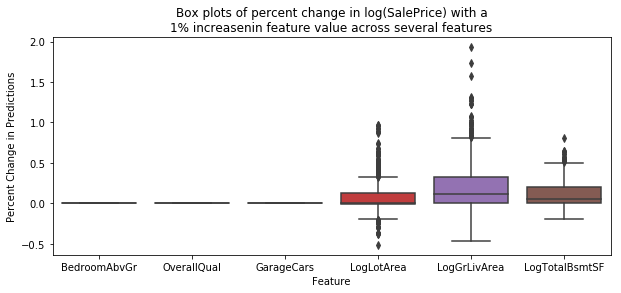

In [43]:
plot_boxplot(pos_one_pc_df, '1% increase')

So how do we read this plot? The x-axis represents features whose values we perturbed with a 1% increase across the board for every sample. The y-axis represents the percent increase or decrease in prediction value relative to the predictions generated via the unperturbed data. These perturbations were done independently of one another so the box plot of `BedroomAbvGr` only shows you the impact of perturbing that feature _and nothing else_. 

A robust model is one where a small percentage change has minimal impact on the predicted outcomes which means we want to see boxplots where most of the data is centered around 0 (which means the perturbations on a specific feature basically had no impact on predictions!) 

Looking at this, we can see that seems to be the case -- for three features all of the values are around zero and the remaining three the majority are between 0 and 0.5% percent increase! 

The nice thing about creating such generalizable functions is it's very easy to try different values. For example, determining the impact of 1% decrease across different features is as easy as this: 

In [44]:
neg_one_pc_df = percent_change_impact(final_model_processed_no_null_test_features, 
                                      relevant_columns, 
                                      -1, 
                                      final_gb_model, 
                                      original_predictions)

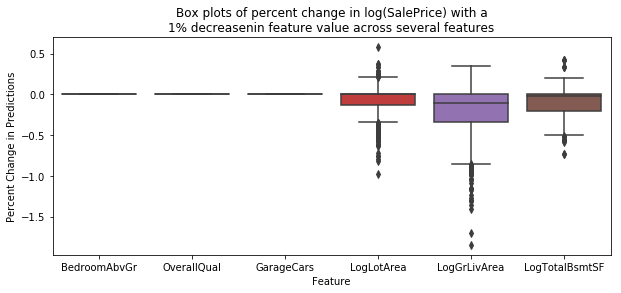

In [45]:
plot_boxplot(neg_one_pc_df, '1% decrease')

The results are not as good as the previous one, but they are still generally in the 0-0.5% percent change range, which is awesome! 

Let's take it one step further and do 5% increase and 5% decrease: 

In [46]:
pos_five_pc_df = percent_change_impact(final_model_processed_no_null_test_features, 
                                      relevant_columns, 
                                      5, 
                                      final_gb_model, 
                                      original_predictions)

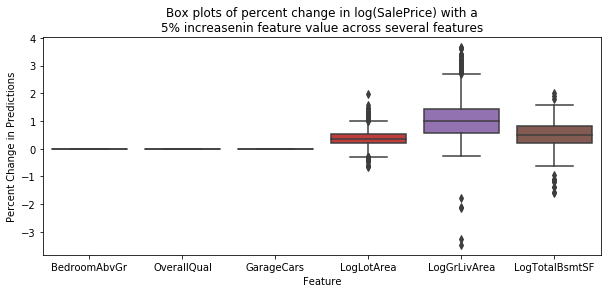

In [47]:
plot_boxplot(pos_five_pc_df, '5% increase')

In [48]:
neg_five_pc_df = percent_change_impact(final_model_processed_no_null_test_features, 
                                      relevant_columns, 
                                      -5, 
                                      final_gb_model, 
                                      original_predictions)

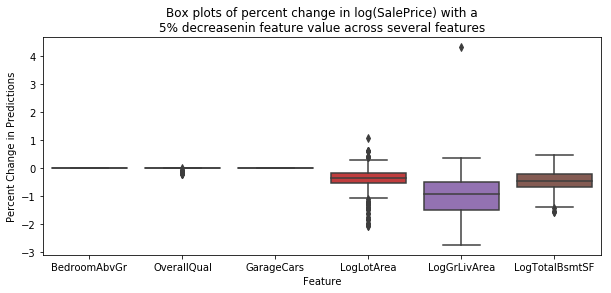

In [49]:
plot_boxplot(neg_five_pc_df, '5% decrease')

Once again, I would argue that these plots indicate that the model is quite robust to small perturbations. Even when I cause a 5% change to all the values of a feature, the percent change in final predictions is still between 0 to 1% percent change, which is pretty good! 

Thus, based on the results of my imputation test and my percent change test, I believe my model is quite robust. 

# Statistical significance

The next thing I had to focus on was determining whether my new model was statistically significant better than the initial benchmark. But how do I do that if I currently only have one RMSE value--0.15922--to go off of? The answer is that I can create my own distribution! 

But how? The answer, as it turns out, is by using graident boosting's randomness to my advantage. If you remember from before, I have always used `random_state=39` to pin down the gradient boosting model so that I don't have to worry about data changing if I need to rerun the kernel. By changing the `random_state`, however, I can get slightly different predictions. In turn, I can use these different predictions to get slightly different test RMSE values and ultimately create a group distribution. Once I have that distribution, I can run a t-test between the group's results and the benchmark value.

## Test data prep

As always, we need to make sure the test data is properly processed and processed the same way I did previously

In [50]:
final_model_test_features = test_data[['LotArea', 'BedroomAbvGr', 'MoSold', 'YrSold', 
                                       'OverallQual', 'GrLivArea', 'Neighborhood', 
                                       'TotalBsmtSF', 'GarageCars', 'ExterQual', 
                                       'BsmtQual', 'KitchenQual']]

final_model_fillna_features = final_model_test_features.fillna(final_model_test_features.mean())
final_model_fillna_features['KitchenQual'] = final_model_test_features['KitchenQual'].fillna('TA')
final_model_fillna_features.isnull().sum()

# TotalBsmtSF can sometimes be 0 so we must add 1
final_model_processed_test_cont_features = log_transform_features(final_model_fillna_features, 
                                                                  ['LotArea', 'GrLivArea', 'TotalBsmtSF'], 
                                                                 add_value=True)
final_model_processed_test_features = pd.get_dummies(final_model_processed_test_cont_features)
final_model_processed_test_features.head()

,BedroomAbvGr,MoSold,YrSold,OverallQual,GarageCars,LogLotArea,LogGrLivArea,LogTotalBsmtSF,Neighborhood_Blmngtn,Neighborhood_Blueste,...,ExterQual_Gd,ExterQual_TA,BsmtQual_Ex,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_TA,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA
0,2,6,2010,5,1.0,9.360741,6.799056,6.783325,0,0,...,0,1,0,0,0,1,0,0,0,1
1,3,6,2010,6,1.0,9.565775,7.192934,7.192934,0,0,...,0,1,0,0,0,1,0,0,1,0
2,3,3,2010,5,2.0,9.534668,7.396335,6.834109,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,6,2010,6,2.0,9.208238,7.380879,6.831954,0,0,...,0,1,0,0,0,1,0,0,1,0
4,2,1,2010,8,2.0,8.518392,7.155396,7.155396,0,0,...,1,0,0,0,1,0,0,0,1,0


## Testing 

Now that I have the test data correctly preprocessed, it's now time to change the `random_state` of the model for each iteration, make predictions on the test data and then submit to Kaggle. Of course, every time we create a new model we first must refit it on the training data and then make predictions.

To make this process as straightforward as possible, I have created two helper functions. 

In [51]:
def transform_and_save_predictions(predictions, filepath):
    # You have to un-log transform the predictions!
    prediction_data = {'Id': range(1461, 1461+len(predictions)), 'SalePrice': np.exp(predictions)}
    predictions_df = pd.DataFrame(prediction_data)
    predictions_df.to_csv(filepath, index=False)
    
def new_predictions(random_ints, train_features, train_target, test_feature):
    for i, r in enumerate(random_ints): 
        # Create a "new" model using a different random seed
        new_model = GradientBoostingRegressor(loss='lad', max_depth=3, min_samples_leaf=1, 
                                     learning_rate=0.1, random_state=r, n_estimators=700)
        new_model.fit(train_features, train_target)
        predicted_test_results = new_model.predict(test_feature)
        transform_and_save_predictions(predicted_test_results, './data/stat-sig/{}-{}result.csv'.format(i, r))

In [52]:
# https://stackoverflow.com/questions/22842289/generate-n-unique-random-numbers-within-a-range
import random

# random.sample(range(1, 100), 10) <-- used this function to generate 10 random ints
random_int_list = [29, 28, 66, 33, 95, 70, 16, 79, 49, 56] # <-- these were the ints that were generated. 

Now that we have the list of random seeds let's generate 10 sets of new predictions. I will then have to submit each prediction set to Kaggle. 

In [53]:
new_predictions(random_int_list, 
                final_model_processed_features, 
                final_model_processed_target, 
                final_model_processed_test_features)

After submitting to Kaggle, I got 10 different test RMSE listed below, which I will save into this numpy array. Again, the only thing I change in each iteration was a random_state so the RMSE should be similar to one another.  

In [54]:
test_RMSE = np.array([0.16231, 0.15852, 0.15896, .16077, 0.15942, 0.16110, 0.16191, 0.16191, 0.16086, 0.15980])

In [55]:
print(test_RMSE.mean())
print(test_RMSE.std())

0.160556
0.00125426631941


Now that I have this, I can easily run a one-sample t-test to see if my model's performance is statistically significant to the benchmark. 

In [56]:
# https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.ttest_1samp.html

from scipy import stats

stats.ttest_1samp(test_RMSE,0.40890)

Ttest_1sampResult(statistic=-593.99825098704025, pvalue=5.5304314980902093e-22)

# Free form visualizations

For the free form visualization section, I have two things I wanted to explore: seasonality and train v. test set feature distributions. Together these two plots could suggest next directions to improve my model further.  

## Seasonality 

The first thing I wanted to explore is seasonality. Based on my previous experience I hear that house prices generally go up over time and that certain months of the year are better than others to sell a house. Although we include month and year as features in our model, could we potentially need to use more complex methods to properly handle them? A simple timeseries can help here. 

First, we need to create a dataframe that makes accessing this information easy and straightforward. 

In [57]:
seasonality = train_data[['MoSold', 'YrSold', 'SalePrice']].groupby(['YrSold','MoSold']).mean()
seasonality

SalePrice
YrSold MoSold               
2006   1       201090.000000
       2       194322.222222
       3       184982.200000
       4       174312.814815
       5       158928.289474
       6       172283.333333
       7       183211.059701
       8       196239.956522
       9       223768.866667
       10      172356.708333
       11      213285.000000
       12      185545.000000
2007   1       183234.615385
       2       176301.750000
       3       176567.782609
       4       170772.608696
       5       169873.511628
       6       179725.813559
       7       195396.843137
       8       183941.075000
       9       195533.818182
       10      215428.812500
       11      197709.333333
       12      214414.500000
2008   1       178504.692308
       2       159370.000000
       3       178505.277778
       4       159293.346154
       5       188334.473684
       6       169730.941176
       7       174562.653061
       8       196076.965517
       9       169626.470588
       10      166690.636364
       11      210981.058824
       12      175600.000000
2009   1       189735.500000
       2       187450.000000
       3       171547.368421
       4       181680.769231
       5       164482.945946
       6       183260.932203
       7       197984.409836
       8       165670.966667
       9       196849.350000
       10      175206.592593
       11      156381.818182
       12      164014.533333
2010   1       163852.600000
       2       174823.333333
       3       203181.285714
       4       171344.025641
       5       178422.250000
       6       181639.583333
       7       121750.000000

Now that we have that, let's compute some summary statistics for both month and year. 

In [58]:
seasonality.groupby('MoSold').agg(['mean', 'median'])

SalePrice               
                 mean         median
MoSold                              
1       183283.481538  183234.615385
2       178453.461111  176301.750000
3       182956.782904  178505.277778
4       171480.712907  171344.025641
5       172008.294146  169873.511628
6       177328.120721  179725.813559
7       174580.993147  183211.059701
8       185482.240926  190009.020259
9       196444.626359  196191.584091
10      182420.687447  173781.650463
11      194589.302585  204345.196078
12      184893.508333  180572.500000

In [59]:
seasonality.groupby('YrSold').agg(['mean', 'median'])

SalePrice               
                 mean         median
YrSold                              
2006    188360.454256  185263.600000
2007    188241.705336  183587.845192
2008    177273.042954  175081.326531
2009    177855.432201  178443.680912
2010    170716.154003  174823.333333

Just by looking at these two tables it does appear that both month and year seem to have an impact on mean and median `SalePrice`. 

Now lets make that timeseries plot. Unforunately, I had to get a little creative with getting the x-axis to be better labeled. The whole process is below: 

In [60]:
from datetime import datetime

def create_labels(): 
    time_label = []
    for yr in range(6, 11):
        for mo in range(1, 13):
            if yr < 10:
                nyr = '0' + str(yr)
            else:
                nyr = str(yr)
            
            if mo < 10: 
                nmo = '0' + str(mo)
            else:
                nmo = str(mo)
                
            time_label.append('{}-{}'.format(nmo, nyr))
    return time_label

In [61]:
time_labels = create_labels()[:-5]

/Users/mihaimsirbu/anaconda/envs/capstone/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


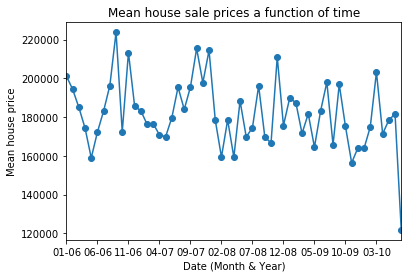

In [62]:
# https://stackoverflow.com/questions/49227504/valueerror-could-not-convert-string-to-float-sns-tsplot-time-using-strings
# https://stackoverflow.com/questions/27986268/how-can-i-set-multiple-markers-with-tsplot

plt.xticks(range(0, 55, 5),time_labels[0:55:5])
sns.tsplot(seasonality['SalePrice'], marker="o").set_title('Mean house sale prices a function of time')
plt.xlabel('Date (Month & Year)')
plt.ylabel('Mean house price')


So what can we see here? Well it appears that the differences noted in the summary statistics are also in play here. Specifically, we can see a slight decrease in house prices over time just by looking at the year. At the same time, we if look within a year, the pattern of house prices going up between June and September and then decreasing afterward seems consistent year to year. Thus, seasonslity does appear to be present. 

## Train vs Test Feature Distribution

The second question I wanted to know whas whether the training and test sets had different underlying distributions for continous features. This is important because if the train and test set are radically different than model performance could really suffer. This not only could explain why my model didn't perform as well as it could have but it also could indicate that I would need to do more sophisticated preprocessing to handle these differences between train and test sets. 

To make my life easier, I focused on continous variables columns. Once again I identified them programatically. 

In [63]:
final_model_processed_features.dtypes

BedroomAbvGr              int64
MoSold                    int64
YrSold                    int64
OverallQual               int64
GarageCars                int64
LogLotArea              float64
LogGrLivArea            float64
LogTotalBsmtSF          float64
Neighborhood_Blmngtn      uint8
Neighborhood_Blueste      uint8
Neighborhood_BrDale       uint8
Neighborhood_BrkSide      uint8
Neighborhood_ClearCr      uint8
Neighborhood_CollgCr      uint8
Neighborhood_Crawfor      uint8
Neighborhood_Edwards      uint8
Neighborhood_Gilbert      uint8
Neighborhood_IDOTRR       uint8
Neighborhood_MeadowV      uint8
Neighborhood_Mitchel      uint8
Neighborhood_NAmes        uint8
Neighborhood_NPkVill      uint8
Neighborhood_NWAmes       uint8
Neighborhood_NoRidge      uint8
Neighborhood_NridgHt      uint8
Neighborhood_OldTown      uint8
Neighborhood_SWISU        uint8
Neighborhood_Sawyer       uint8
Neighborhood_SawyerW      uint8
Neighborhood_Somerst      uint8
Neighborhood_StoneBr      uint8
Neighbor

Thus to only get the continuous features I can use the following check: 

In [64]:
final_model_processed_features.dtypes[final_model_processed_features.dtypes != 'uint8'].index

Index(['BedroomAbvGr', 'MoSold', 'YrSold', 'OverallQual', 'GarageCars',
       'LogLotArea', 'LogGrLivArea', 'LogTotalBsmtSF'],
      dtype='object')

Now to visualize this information, I need to create a plot where every subplot compares the train and test distribution for a specific feature. To make it even more powerful, the train and test distribution should be on the same plot to make overlapping as clear as possible. 

Achieving this took a lot of time but I was able to do this with the following function 

In [65]:
from math import floor 

# https://seaborn.pydata.org/examples/distplot_options.html
# https://python-graph-gallery.com/25-histogram-with-several-variables-seaborn/
# https://matplotlib.org/gallery/subplots_axes_and_figures/subplots_demo.html
# https://matplotlib.org/gallery/subplots_axes_and_figures/figure_title.html#sphx-glr-gallery-subplots-axes-and-figures-figure-title-py
# https://stackoverflow.com/questions/8248467/matplotlib-tight-layout-doesnt-take-into-account-figure-suptitle

def plot_train_test_distributions(train_df, test_df):
    # Filter out non continuous features
    columns = train_df.dtypes[train_df.dtypes != 'uint8'].index
    
    
    f, ax = plt.subplots(int(len(columns) / 2), 2, figsize=(15,20))
    
    # Go through each feature and plot the train and test set distribution on the same subplot
    for i, c in enumerate(columns):
        sns.distplot(train_df[c], 
                     color="skyblue", 
                     label="{} (Train)".format(c), 
                     ax=ax[floor(i/2), i % 2])
        sns.distplot(test_df[c], 
                     color="red", 
                     label="{} (Test)".format(c),  
                     ax=ax[floor(i/2), i % 2])
        ax[floor(i/2), i % 2].set(ylabel='Probability Density')
        ax[floor(i/2), i % 2].legend()
        ax[floor(i/2), i % 2].set_title('Train & Test Distribution for Feature {}'.format(c))
        
    # Some nice plot formatting.     
    plt.suptitle('Feature Distributions Across Train and Test datasets', fontsize=14)
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.show()

Running the function produced the following plot: 

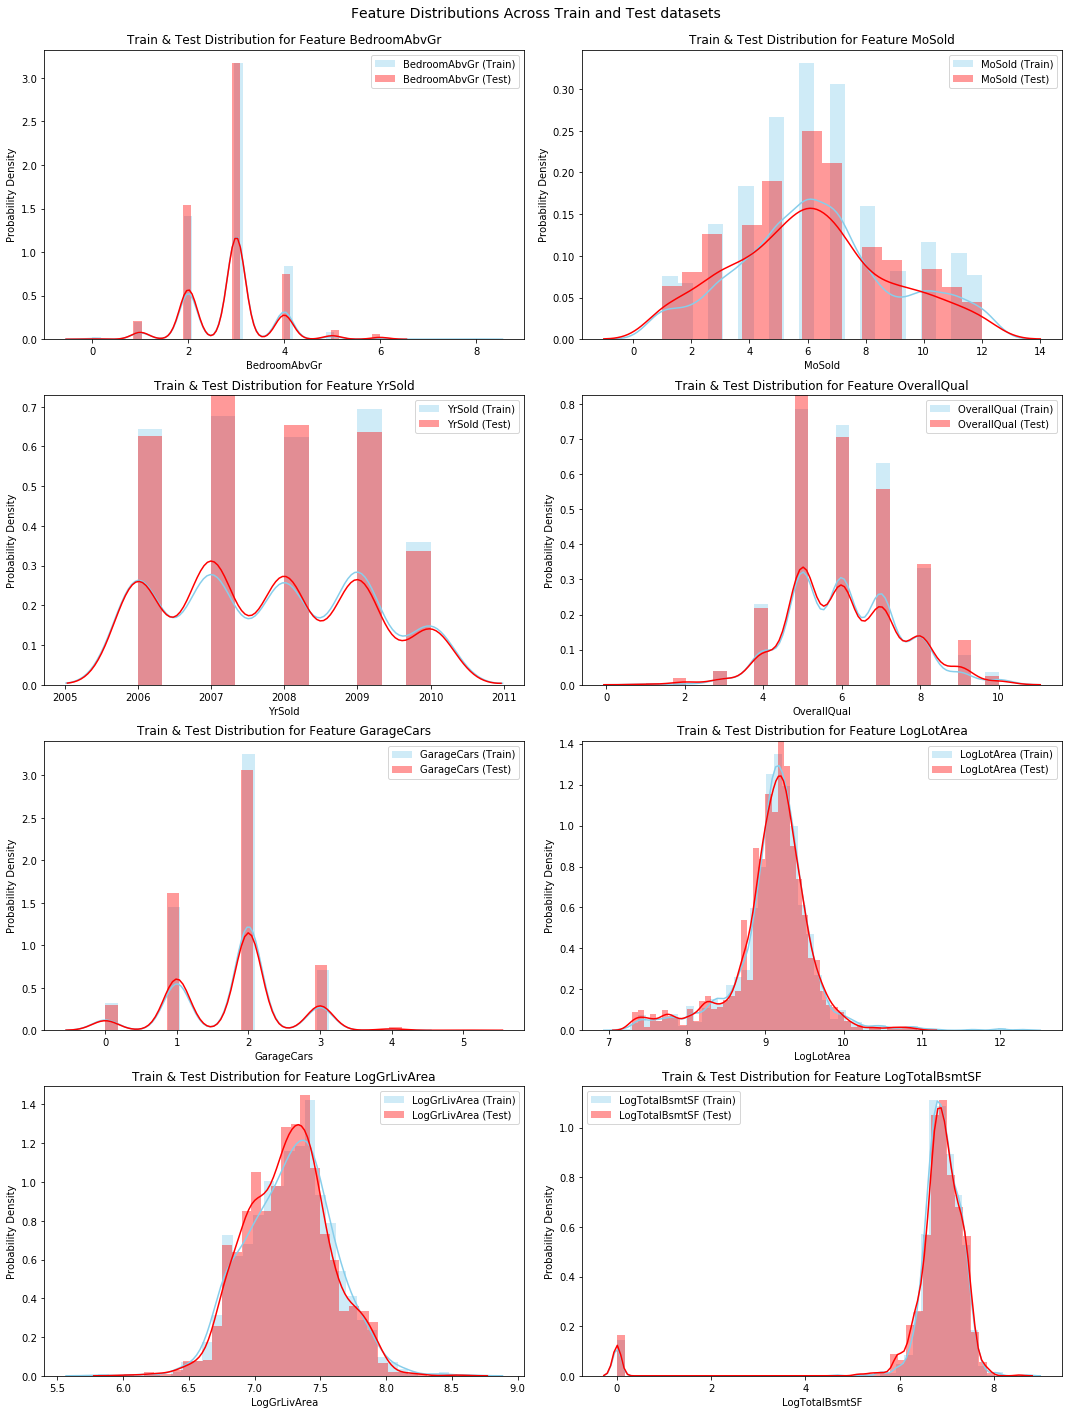

In [66]:
plot_train_test_distributions(final_model_processed_features, final_model_processed_test_features)

As you can see, the answer is obvious and clear: the train and test set distributions for these 8 features are basically identical so this is not a problem for me and this _not_ impact my model's performance. 

# Conclusions 

In this notebook we did several important things. From top to bottom I: 
    
* Showed how my model was robust to small perturbations
* Showed that my model had statistically significant better performance (measured via test RMSE) to the initial benchmark 
* Created two visualizations that showed that seasonality could be something future models could better address and that the a feature's distribution in the training set was basically identical to that feature's distribution in the test set, which is something we definitely wanted! 